![](figure/dumbbell_2d.svg)

In [5]:
%matplotlib widget
%reset -f
%load_ext autoreload
%autoreload 1
%aimport mechanics

from sympy import *
from mechanics import *
import mechanics.space as space

t, = base_spaces('t')
def dot(f): return diff(f, t)

# Generalized coordinates
r, = variables('r', t)
theta, psi = variables(r'\theta, \psi', t, space=space.S)

q = r, theta, psi
dq = tuple(dot(q_n) for q_n in q)
ddq = tuple(dot(dq_n) for dq_n in dq)

# Parameters
# mu: gravitational constant of central body
# m: mass of dumbbell satellite
# I: moment of inertia of dumbbell satellite about mass center
# l: length of dumbbell satellite
mu, m, I, l = constants(r'\mu m I \ell')

# Position of mass center 
x1 = r * cos(theta)
x2 = r * sin(theta)
v1 = dot(x1)
v2 = dot(x2)

# Eccentricity and Runge-Lenz vector
e1 = (((v1**2 + v2**2)/mu - 1/r) * x1 - (x1 * v1 + x2 * v2) / mu * v1).simplify()
e2 = (((v1**2 + v2**2)/mu - 1/r) * x2 - (x1 * v1 + x2 * v2) / mu * v2).simplify()
e = sqrt(e1 ** 2 + e2 ** 2).simplify()
A1 = (mu*m**2 * e1).simplify()
A2 = (mu*m**2 * e2).simplify()
A = sqrt(A1**2 + A2**2).simplify()
show(r'\mathbf{e} =', (e1, e2))
show(r'e =', e)
show(r'\mathbf{A} =', (A1, A2))
show(r'A =', A)

# Position of two masses
x_a1 = x1 + l/2 * cos(theta + psi)
x_a2 = x2 + l/2 * sin(theta + psi)
x_b1 = x1 - l/2 * cos(theta + psi)
x_b2 = x2 - l/2 * sin(theta + psi)

# Lagrangian
U = - mu*m / r - mu/2 / r**3 * (2*I - 3*I*sin(psi)**2)
T = m/2 * dot(r)**2 + m/2 * (r*dot(theta))**2 + I/2 * (dot(theta + psi))**2
E = T + U
L = T - U
show('L =' , L)

from mechanics.lagrange import legendre_transform, euler_lagrange_equation

# Momenta and Hamiltonian
p, H, FL = legendre_transform(L, q, dq)
H = H.simplify()
show_equations(p)
show('H =', H)

p_r, p_theta, p_psi = p.values()
Phi = p_theta - p_psi # Orbital angular momentum
show(r'\Phi =', Phi)

# Euler-Lagrange equations
EL = euler_lagrange_equation(L, q)
show_equations(EL)

F = solve(EL, ddq)
show_equations(F)

tau_g = dot(Phi).subs(F).simplify() # Gravity gradient torque
show(r'\tau_g =', tau_g)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [8]:
%autoreload

from mechanics.integrator.runge_kutta import rk4_explicit

h, T = constants('h T')
i, = indices('i')
X, K, rk4_step, d = rk4_explicit(F, h, i)
show_equations(rk4_step)
r, theta, psi = d(q)
v_r, v_theta, v_psi = d(dq)

<IPython.core.display.Math object>

In [40]:
%autoreload

functions = {'x1': x1, 'x2': x2,
             'x_a1': x_a1, 'x_a2': x_a2,
             'x_b1': x_b1, 'x_b2': x_b2,
             'tau_g': tau_g, 
             'p_r': p_r, 'p_theta': p_theta, 'p_psi': p_psi, 'Phi': Phi,
             'A1': A1, 'A2': A2, 'A': A,
             'E': E}

solver = build_solver()
solver.constants(mu, m, I, l, h, T)
solver.variables(*X, *K, index=(i, 0, T/h))
solver.functions(*functions.keys(), index=(i, 0, T/h))
solver.inputs(*(x[0] for x in X))
with solver.steps(i, 0, T/h) as step:
    step.explicit(rk4_step)
    step.calculate({name: d(func) for name, func in functions.items()}, i)
solver = solver.generate()

Generating Fortran code in /var/folders/pr/76dm89zs5l96s1wmpwys3rqr0000gn/T/tmpus_c27f7/generated.f90


In [45]:
%autoreload
_ = solver.run({
    mu: 1.0, m: 1.0, l: 0.1, I: m * l**2 / 4,
    h: 0.01, T: 100.0,
    r[0]: 1.0, theta[0]: 0.0, psi[0]: 0.0,
    v_r[0]: 0.0, v_theta[0]: 1.1, v_psi[0]: 2.0,
})

{\mu: [1.0], m: [1.0], \ell: [0.1], I: [0.0025000000000000005], h: [0.01], T: [100.0], r(0,): [1.0], \theta(0,): [0.0], \psi(0,): [0.0], v_{r}(0,): [0.0], v_{\theta}(0,): [1.1], v_{\psi}(0,): [2.0]}
Log data in: /var/folders/pr/76dm89zs5l96s1wmpwys3rqr0000gn/T/tmphnv8d8a_/result.log, size=390045


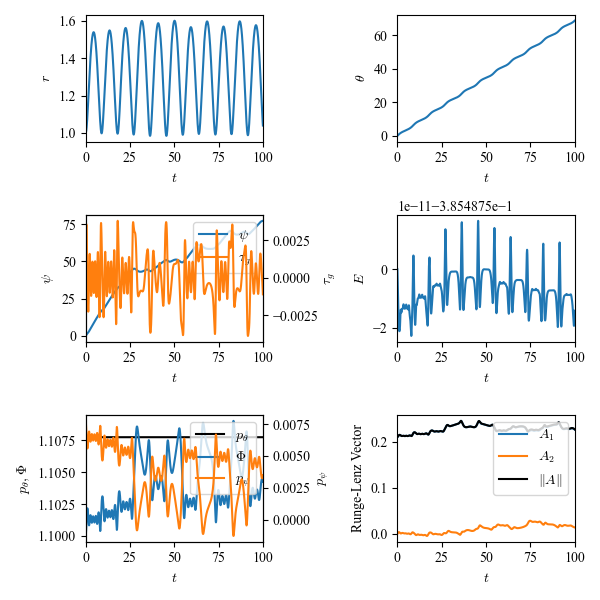

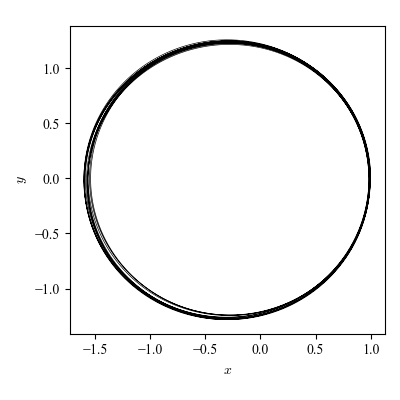

In [51]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'

t = np.arange(0, _[T], _[h])

fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)
ax.plot(_['x1'], _['x2'], color='black', lw=0.5)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal')

fig, axes = plt.subplots(3, 2, figsize=(6, 6), tight_layout=True)
variables = [r, theta, [psi, 'tau_g'], 'E']

for ax in axes.flatten():
    ax.set_xlabel('$t$')
    ax.set_xlim(0, _[T])

ax = axes[0][0]
ax.plot(t, _[r][:-1])
ax.set_ylabel(r'$r$')

ax = axes[0][1]
ax.plot(t, _[theta][:-1])
ax.set_ylabel(r'$\theta$')

ax = axes[1][0]
ax.plot(t, _[psi][:-1], label=r'$\psi$')
ax.set_ylabel(r'$\psi$')
axr = ax.twinx()
axr.plot(t, _['tau_g'][:-1], label=r'$\tau_g$', color='tab:orange')
axr.set_ylabel(r'$\tau_g$')
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = axr.get_legend_handles_labels()
ax.legend(h1 + h2, l1 + l2, loc='upper right')

ax = axes[1][1]
ax.plot(t, _['E'][:-1])
ax.set_ylabel(r'$E$')

ax = axes[2][0]

ax.plot(t, _['p_theta'][:-1], label=r'$p_\theta$', color='black')
ax.plot(t, _['Phi'][:-1], label=r'$\Phi$')
axr = ax.twinx()
axr.plot(t, _['p_psi'][:-1], label=r'$p_\psi$', color='tab:orange')
ymin, ymax = ax.get_ylim()
yminr, ymaxr = axr.get_ylim()
yrange = max(ymax - ymin, ymaxr - yminr)
ax.set_ylim(ymin, ymin + yrange)
axr.set_ylim(yminr, yminr + yrange)
ax.set_ylabel(r'$p_\theta, \Phi$')
axr.set_ylabel(r'$p_\psi$')
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = axr.get_legend_handles_labels()
ax.legend(h1 + h2, l1 + l2, loc='upper right')

ax = axes[2][1]
ax.plot(t, _['A1'][:-1], label=r'$A_1$')
ax.plot(t, _['A2'][:-1], label=r'$A_2$')
ax.plot(t, _['A'][:-1], label=r'$\|A\|$', color='black')
ax.legend(loc='upper right')
ax.set_ylabel('Runge-Lenz Vector')

plt.show()